In [1]:
import sys
assert sys.version_info>=(3,5)

In [2]:
import sklearn
import numpy as np
import os

In [3]:
#To plot pritty plot
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('axes',labelsize=14)
mpl.rc('xtick',labelsize=12)
mpl.rc('ytick',labelsize=12)

In [4]:
#Where to save figures
PROJECT_ROOT_DIR="."
CHAPTER_ID="end_to_end_project"
IMAGE_PATH=os.path.join(PROJECT_ROOT_DIR,"images",CHAPTER_ID)
os.makedirs(IMAGE_PATH,exist_ok=True)

In [14]:
def save_fig(fig_id,tight_layout=True,fig_extensions="png",resolution=300):
  path=os.path.join(IMAGE_PATH,fig_id +"."+fig_extensions)
  print("Saving figure",fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path,format=fig_extensions,dpi=resolution)

#Ignore useless warning (see Scipy issue #5998)
import warnings
warnings.filterwarnings(action="ignore",message="^internal gelsd")


## Get the data

In [6]:
import tarfile
import urllib
DOWNLOAD_ROOT="https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH=os.path.join("datasets","housing")
HOUSING_URL=DOWNLOAD_ROOT+"datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL,housing_path=HOUSING_PATH):
  if not os.path.isdir(housing_path):
    os.makedirs(housing_path)
  tgz_path=os.path.join(housing_path,"housing.tgz")
  urllib.request.urlretrieve(housing_url,tgz_path)
  housing_tgz=tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()


In [7]:
fetch_housing_data()

In [8]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path=os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

In [9]:
housing=load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [10]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [11]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [12]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Saving figure attribute_histogram_plots


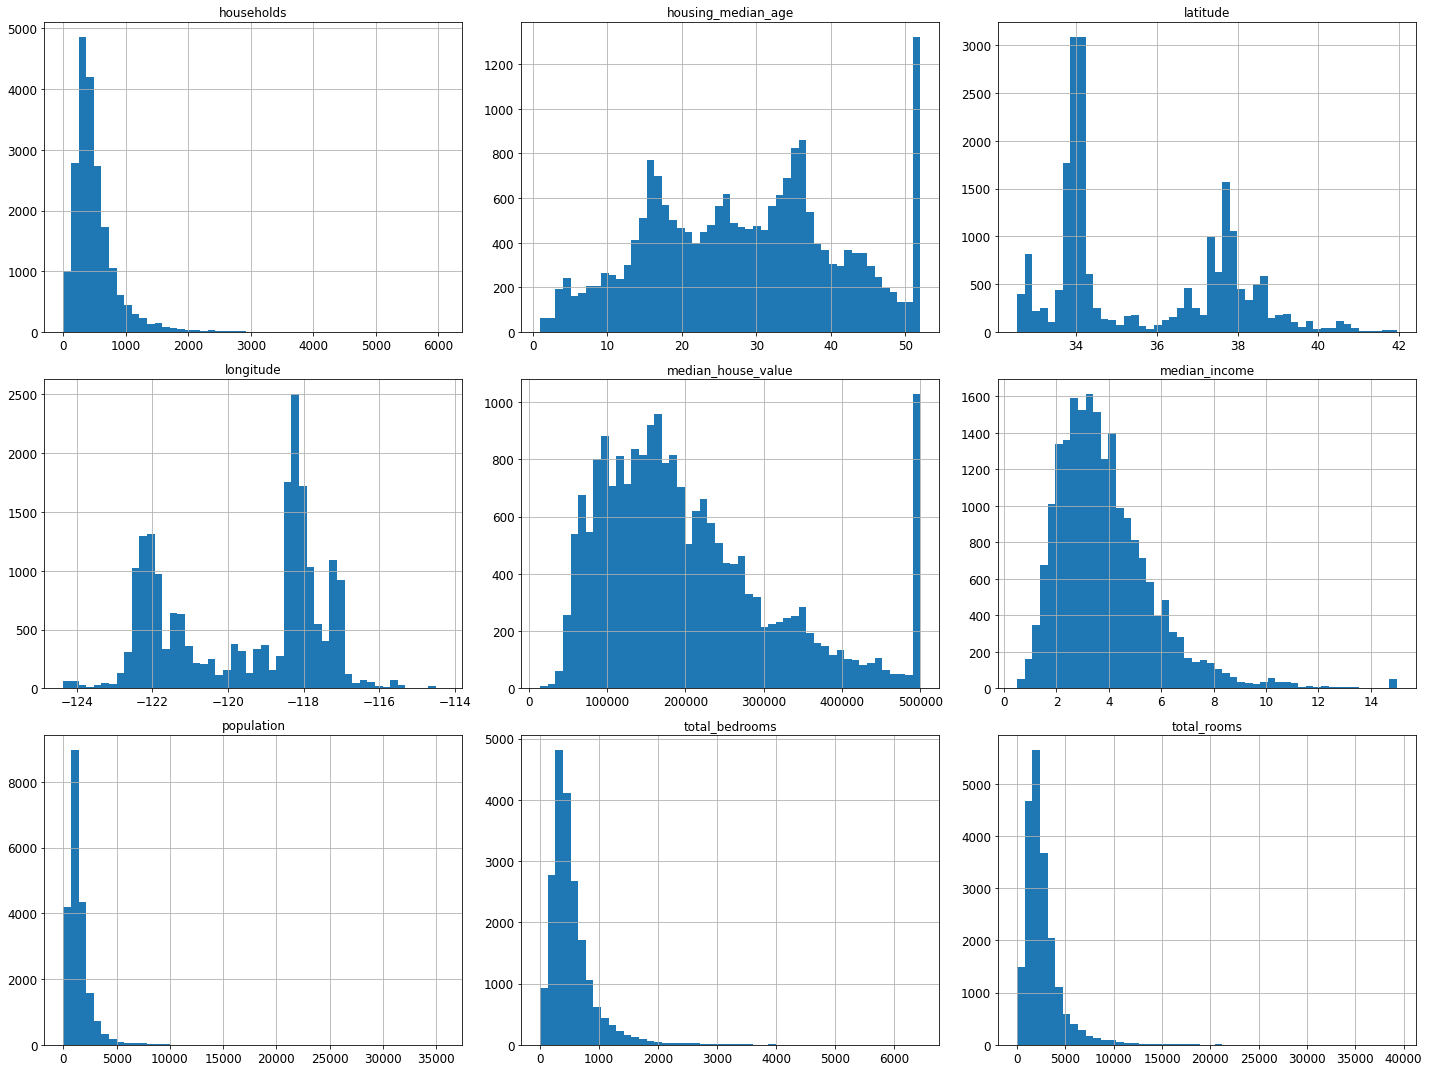

In [15]:
%matplotlib inline 
import matplotlib.pyplot as plt
housing.hist(bins=50,figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [16]:
#to make this notebook identical at every run
np.random.seed(42)

In [17]:
import numpy as np

#For illustration only ,Sklearn has train_test_split()
def split_train_test(data,test_ratio):
  shuffled_indices=np.random.permutation(len(data))
  test_size=int(len(data)*test_ratio)
  test_indices=shuffled_indices[:test_size]
  train_indices=shuffled_indices[test_size:]
  return data.iloc[train_indices],data.iloc[test_indices]


In [18]:
train_set,test_set=split_train_test(housing,0.2)
len(train_set)

16512

In [19]:
len(test_set)

4128

In [25]:
from zlib import crc32
def test_set_check(identifier,test_ratio):
  return crc32(np.int64(identifier)) & 0xffffffff <test_ratio*2**32

def split_train_test_set_by_id(data,test_ratio,id_column):
  ids=data[id_column]
  in_test_set=ids.apply(lambda id_:test_set_check(id_,test_ratio))
  return data.loc[~in_test_set],data.loc[in_test_set]


In [26]:
housing_with_id=housing.reset_index() ## add an index column
train_set,test_set=split_train_test_set_by_id(housing_with_id,0.2,"index")

In [27]:
housing_with_id['id']=housing["longitude"]*1000+housing["latitude"]
train_set,test_set=split_train_test_set_by_id(housing_with_id,0.2,"id")

In [28]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19
67,67,-122.29,37.80,52.0,1027.0,244.0,492.0,147.0,2.6094,81300.0,NEAR BAY,-122252.20


In [29]:
from sklearn.model_selection import train_test_split
train_set,test_set=train_test_split(housing,test_size=0.2,random_state=42)

In [30]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


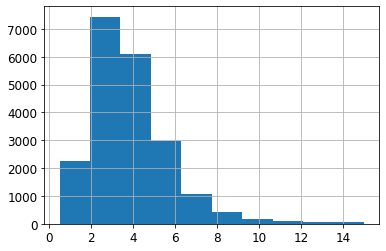

In [31]:
housing['median_income'].hist()

In [32]:
housing["income_cate"]=pd.cut(housing['median_income'],
                              bins=[0,1.5,3.0,4.5,6.0,np.inf],
                              labels=[1,2,3,4,5])

In [34]:
housing["income_cate"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cate, dtype: int64

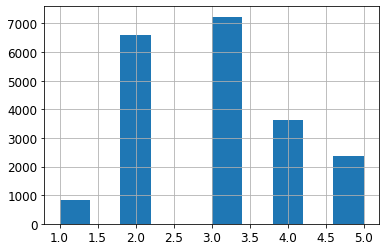

In [35]:
housing["income_cate"].hist()

In [40]:
housing.rename(columns={"income_cate":"income_cat"},inplace=True)

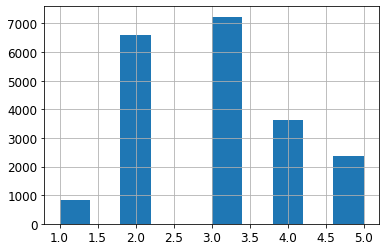

In [41]:
housing["income_cat"].hist()

**Stratified sampling based on the income category**


In [45]:
from sklearn.model_selection import StratifiedShuffleSplit

split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in split.split(housing,housing['income_cat']):
  strait_train_set=housing.loc[train_index]
  strait_test_set=housing.loc[test_index]

In [46]:
strait_test_set["income_cat"].value_counts()/len(strait_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [47]:
housing["income_cat"].value_counts()/len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [49]:
def income_cat_proportion(data):
  return data["income_cat"].value_counts()/len(data)
train_set,test_set=train_test_split(housing,test_size=0.2,random_state=42)

compare_props=pd.DataFrame({
    "Overall":income_cat_proportion(housing),
    "Stratified":income_cat_proportion(strait_test_set),
    "Random":income_cat_proportion(test_set)
}).sort_index()

compare_props["Rand. %error"]=100*compare_props["Random"]/compare_props["Overall"]-100
compare_props["Strat. % error"]=100*compare_props["Stratified"]/compare_props["Overall"]-100


In [50]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. % error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


Here we can see Stratified has good distribution

Now drop  column income_cat

In [51]:
for set_ in (strait_train_set,strait_test_set):
  set_.drop("income_cat",axis=1,inplace=True)

Discover and visualize the data to gain insight.

In [52]:
housing=strait_train_set.copy()

Saving figure bad_visulization_plot


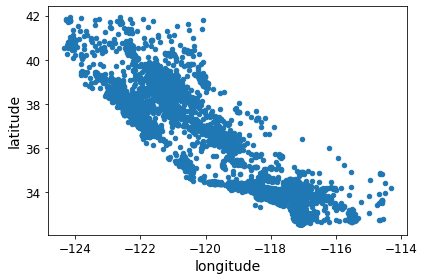

In [53]:
housing.plot(kind="scatter",x="longitude",y="latitude")
save_fig("bad_visulization_plot")

Saving figure better_visualization_plot


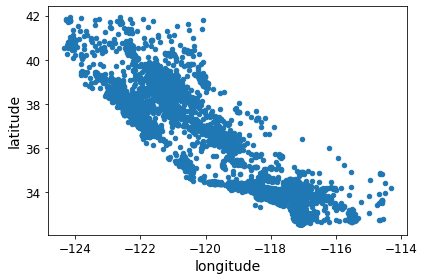

In [55]:
housing.plot(kind="scatter",x="longitude",y="latitude")
save_fig("better_visualization_plot")


Saving figure Housing_price_scatterplot


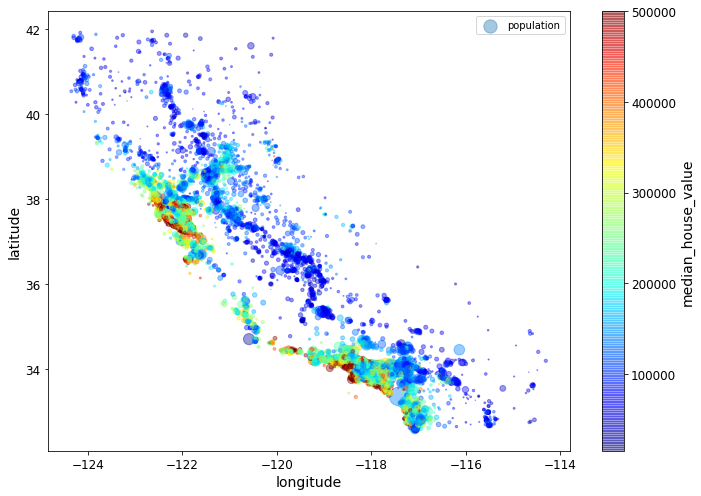

In [60]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.4,
             s=housing["population"]/100,label="population",figsize=(10,7),
             c="median_house_value",cmap=plt.get_cmap("jet"),colorbar=True,
             sharex=False)
plt.legend()
save_fig("Housing_price_scatterplot")